In [1]:
"""
Segundo Bourdin, 1999.



Novo funcional:
E_c(u, v) = Integral(
                beta * (u - g)^2 +
                (v^2 + k_c) * |grad u|^2 +
                2*(alpha/pi)*(c * |grad v|^2 +
                              ((1 - v)^2)/(4*c))
              )
Quando c -> 0, o funcional gama-converge
para funcional que compartilha u com o funcional de Mumford


Euler-Lagrange de funcional em u (fixando v):
beta * (u - g) - (v^2 + k_c) * Laplaciano(u) = 0
u - (v^2 + k_c)/beta * Laplaciano(u) = g


Euler-Lagrange de funcional em v (fixando u):
v*|grad u|^2 + (alpha/pi)*(-(1 - v)/(2*c) - 2*c*Laplaciano(v)) = 0
v*(|grad u|^2 + (alpha/(2*pi*c))) - 2*(alpha/pi)*c*Laplaciano(v) = (alpha/(2*pi*c))



Algoritmo, descrito vagamente no artigo:
Escolher (u_0, v_0).
Calcular iterativamente:
    u_n = min(u) E_c(u, v_(n-1))
    v_n = min(v) E_c(u_n, v)

O autor nota que quando os nós da malha do MEF coincidem com
os centros dos pixels, o problema coincide com o das diferenças
finitas.
"""

'\nSegundo Bourdin, 1999.\n\n\n\nNovo funcional:\nE_c(u, v) = Integral(\n                beta * (u - g)^2 +\n                (v^2 + k_c) * |grad u|^2 +\n                2*(alpha/pi)*(c * |grad v|^2 +\n                              ((1 - v)^2)/(4*c))\n              )\nQuando c -> 0, o funcional gama-converge\npara funcional que compartilha u com o funcional de Mumford\n\n\nEuler-Lagrange de funcional em u (fixando v):\nbeta * (u - g) - (v^2 + k_c) * Laplaciano(u) = 0\nu - (v^2 + k_c)/beta * Laplaciano(u) = g\n\n\nEuler-Lagrange de funcional em v (fixando u):\nv*|grad u|^2 + (alpha/pi)*(-(1 - v)/(2*c) - 2*c*Laplaciano(v)) = 0\nv*(|grad u|^2 + (alpha/(2*pi*c))) - 2*(alpha/pi)*c*Laplaciano(v) = (alpha/(2*pi*c))\n\n\n\nAlgoritmo, descrito vagamente no artigo:\nEscolher (u_0, v_0).\nCalcular iterativamente:\n    u_n = min(u) E_c(u, v_(n-1))\n    v_n = min(v) E_c(u_n, v)\n\nO autor nota que quando os nós da malha do MEF coincidem com\nos centros dos pixels, o problema coincide com o das difer

In [4]:
import os
import numpy as np
import scipy.sparse as sparse
from scipy.sparse import linalg
from scipy.ndimage import correlate, gaussian_filter
import matplotlib.pyplot as plt
import pydicom as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [5]:
def imgtrim(img, c):
    img[img < -c] = -c
    img[img > c] = c
    return img

def imgpow(img, a, b, c, vmax = 0):
    img[img < a] = a
    img[img > b] = b
    img -= np.min(img)
    if vmax == 0:
        img = img / (b-a)
    else:
        img = img / np.max([b-a, vmax])
    img = np.power(img, c)
    return img

In [6]:
class DICOM:
    """Esta classe é usada para armazenar a imagem importada usando a biblioteca Pydicom.
    Tanto uma única imagem Dicom como uma pasta correspondente a uma imagem tridimensional podem ser carregados.
    No caso tridimensional, as fatias são ordenadas e disponibilizadas como um tensor de ordem 3 em self.pixel_array"""
    # Os códigos de tag abaixo são definidos pelo padrão DICOM
    _img_pos = pd.tag.Tag(0x00200032)
    _img_ori = pd.tag.Tag(0x00200037)
    _pct_pos = pd.tag.Tag(0x00185100)
    _slice_thickness = pd.tag.Tag(0x00180050)
    _pixel_spacing = pd.tag.Tag(0x00280030)
    
    def __init__(self, path, d3 = False, file_ext = ".dcm"):
        self.d3 = d3
        self.file_ext = file_ext
        self.path = path
        
        if not d3:
            self.dcm_array = [pd.dcmread(path)]
            self.pixel_array = np.array([self.dcm_array[0].pixel_array])
        else:
            dcm_array = []
            for filename in os.listdir(path):
                if filename.endswith(file_ext):
                    dcm_array.append(pd.dcmread((os.path.join(path, filename))))
            dcm_array.sort(key = lambda x: x[DICOM._img_pos].value[2])
            self.dcm_array = dcm_array
            
            pixel_array = []
            for dcm in dcm_array:
                pixel_array.append(dcm.pixel_array)
            self.pixel_array = np.array(pixel_array)
            #self.padded_array = np.pad(pixel_array, ((0,2),(0,0),(0,0)), 'constant', constant_values = np.min(pixel_array))
            #self.pixel_array = self.padded_array[1:-1,:,:]
        self.res = np.array(list(self.dcm_array[0][DICOM._pixel_spacing].value)
                            + [self.dcm_array[0][DICOM._slice_thickness].value], dtype='float')
        self.shape = self.pixel_array.shape
        self.trim()
    
    def trim(self, plt_lower = -256, plt_upper = 256, plt_pow = 1):
        self.plt_lower, self.plt_upper, self.plt_pow = plt_lower, plt_upper, plt_pow
        self.trimmed_array = imgpow(np.array(self.pixel_array), plt_lower, plt_upper, plt_pow, 0)

    def plot(self, img):
        plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
        plt.set_cmap('Greys_r')
        plt.imshow(img)
        plt.plot();
    
    def plotslice(self, z = 0, setparams = False, a = -256, b = 256, c = 1):
        imgO = np.array(self.pixel_array[z])
        if not setparams:
            imgO = imgpow(imgO, self.plt_lower, self.plt_upper, self.plt_pow, np.max(self.pixel_array))
        else:
            imgO = imgpow(imgO, a, b, c, np.max(self.pixel_array))
        self.plot(imgO)
    
    def startinteractiveplot(self, tensor = None, trimmed = True):
        if tensor is None:
            if trimmed:
                self.plt_array = imgpow(np.array(self.pixel_array),
                                        self.plt_lower, self.plt_upper, self.plt_pow, 0)
            else: 
                self.plt_array = np.array(self.pixel_array)
                self.plt_array -= np.min(self.plt_array)
                self.plt_array = self.plt_array/np.max(self.plt_array)
        else:
            self.plt_array = np.array(tensor)
            self.plt_array -= np.min(self.plt_array)
            self.plt_array = self.plt_array/np.max(self.plt_array)
            
        self.fig = plt.figure(facecolor='w', edgecolor='k')
        plt.set_cmap('Greys_r')
        self.ax = self.fig.add_subplot(1,1,1)
        if self.plt_array.ndim == 3:
            self.im = self.ax.imshow(self.plt_array[0], vmin=0.0, vmax=1.0)
        elif self.plt_array.ndim == 4:
            self.im = self.ax.imshow(self.plt_array[(0,0)], vmin=0.0, vmax=1.0)
    
    def interactiveplot(self, z = 0, pixel_data = None):
        if pixel_data is None:
            self.im.set_data(self.plt_array[z])
        else:
            self.im.set_data(pixel_data)
        self.im.axes.figure.canvas.draw()
    
    def interact(self, tensor = None, dynamic_gamma = False, trimmed = True):
        if not dynamic_gamma:
            self.startinteractiveplot(tensor, trimmed = trimmed)
            if (self.plt_array.ndim == 3):
                interact(lambda z: self.interactiveplot(z),
                         z = widgets.IntSlider(min=0,max=-1+self.plt_array.shape[0],step=1,value=0))
            elif (self.plt_array.ndim == 4):
                interact(lambda t,z: self.interactiveplot((t,z)),
                         t = widgets.IntSlider(min=0,max=-1+self.plt_array.shape[0],step=1,value=0),
                         z = widgets.IntSlider(min=0,max=-1+self.plt_array.shape[1],step=1,value=0))
        else:
            self.startinteractiveplot()
            interact(lambda z, a, b, c: self.interactiveplot(pixel_data = imgpow(np.array(self.pixel_array[z]), a, b, c, 0)),
                     z=widgets.IntSlider(min=0,max=len(self.dcm_array)-1,step=1,value=0),
                     a=widgets.IntSlider(min=-2048,max=8192,step=1,value=-256),
                     b=widgets.IntSlider(min=-2048,max=8192,step=1,value=256),
                     c=widgets.FloatSlider(min=0.1,max=2,step=0.1,value=1)
                    );

In [7]:
path = "C:/Users/Demetrius/Desktop/APOLLO/AP-6H6G/09-09-2015-CT THORAX WCONT-94638/3-Body 2.0 WITH CONT CE-62197"
dicom = DICOM(path, d3 = True)

#list(dcm_array[0][DICOM._pixel_spacing].value) + [dcm_array[0][DICOM._slice_thickness].value]

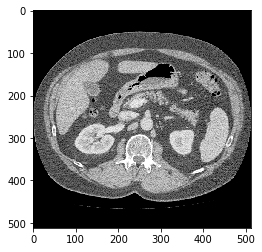

interactive(children=(IntSlider(value=0, description='z', max=157), IntSlider(value=-256, description='a', max…

In [8]:
#%matplotlib
dicom.interact(dynamic_gamma = True)

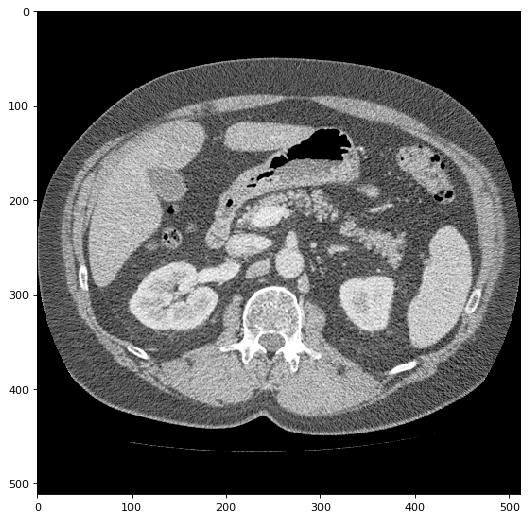

In [9]:
#%matplotlib
#dicom.plotslice()
dicom.plot(dicom.trimmed_array[0])

In [10]:
# v*(|grad u|^2 + (alpha/(2*pi*c))) - 2*(alpha/pi)*c*Laplaciano(v) = (alpha/(2*pi*c))

"""Derivada direcional do tensor.
Parâmetro d determina direção (x,y,z...) = (0,1,2,...).
Parâmetro w determina tipo de estimativa (esquerda, centro, direita) = (-1,0,1)."""
def D(d, w, tensor):
    ndim = 2
    kernel = np.array([0]*(w == 1) + [-1] + [0]*(w==0) + [1] + [0]*(w==-1))
    kernel = np.reshape(kernel, [1]*(ndim-d-1) + [3] + [1]*d)
    if w == 0:
        kernel = kernel * .5
    return correlate(tensor, kernel, mode='nearest')

In [11]:
def A2(u, c, alpha):
    x, y = u.shape
    N = x*y
    Dx = D(0, 0, u)
    Dy = D(1, 0, u)
    norm_grad_u = Dx**2 + Dy**2
    norm_grad_u = norm_grad_u.reshape([N])
    parc1 = norm_grad_u + alpha/(2*np.pi*c)
    parc2 = np.repeat(-alpha*c/np.pi, N)
    A = sparse.dia_matrix(((parc2, parc2, -4*parc2 + parc1, parc2, parc2),(-N, -1, 0, 1, N)), (N, N))
    return sparse.csr_matrix(A)

def b2(u, c, alpha):
    x, y = u.shape
    return np.repeat(alpha/(2*np.pi*c), x*y)

def get_v(u, c, alpha):
    A = A2(u, c, alpha)
    b = b2(u, c, alpha)
    r = linalg.spsolve(A, b)
    # NORMALIZANDO r
    r = r - np.min(r)
    r = r / np.max(r)
    r = r.reshape(u.shape)
    return r

In [12]:
# u - (v^2 + k_c)/beta * Laplaciano(u) = g

def A1(v, k_c, beta):
    x, y = v.shape
    N = x*y
    parcDireta = beta
    parcDx = ((-1)*v*D(0, 0, v)).reshape([N])
    parcDy = ((-1)*v*D(1, 0, v)).reshape([N])
    parcLaplace = (-(v**2 + k_c)).reshape([N])
    
    A = sparse.dia_matrix(((parcLaplace - parcDy, 
                            parcLaplace - parcDx,
                            -4*parcLaplace + parcDireta,
                            parcLaplace + parcDx,
                            parcLaplace + parcDy),
                           (-N, -1, 0, 1, N)),
                          (N, N))
    return sparse.csr_matrix(A)

def b1(img, beta):
    x, y = img.shape
    return beta*img.reshape([x*y])

def get_u(img, v, k_c, beta):
    A = A1(v, k_c, beta)
    b = b1(img, beta)
    r = linalg.spsolve(A, b)
    r = r - np.min(r)
    r = (r / np.max(r))
    r = r.reshape(img.shape)
    return r

In [13]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [175]:
img = rgb2gray(plt.imread('lenna.png'))
#dicom.plot(rgb2gray(img))

#img = 255*gaussian_filter(dicom.trimmed_array[0], 1)

alpha = 10**-3
beta = 10**-1
c = 100
k_c = .1*c

v0 = np.ones(img.shape)
#v0 = -np.ones(img.shape)
#v0[img > np.median(img)] = 1
#v0 = 1 - Dir(gaussian_filter(v0, 3))
#dicom.plot(v0)

0.04541784968911058
0.004251561137558634
0.0002795175924790934
4.234954916325852e-05
2.2461411112494444e-05
5.013219460586494e-06
2.8754940915574143e-06
6.74661862739244e-07
2.8309150744548093e-07
7.134619019489918e-08
2.665181579980777e-08
6.750594849463375e-09
2.4660469429524353e-09
5.698404896697939e-10
2.320102371546531e-10
4.035178597373278e-11
Número de iterações:  17
0.10611927655056119


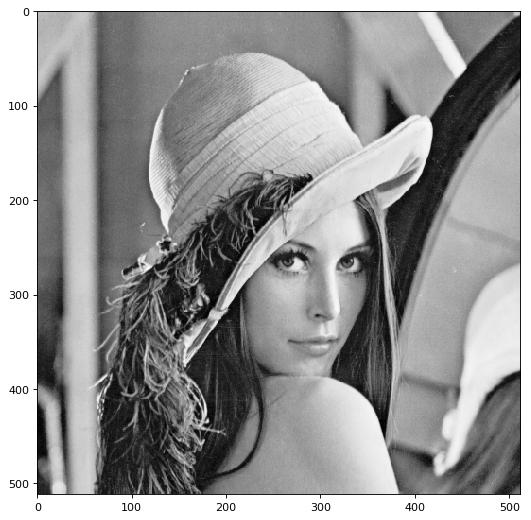

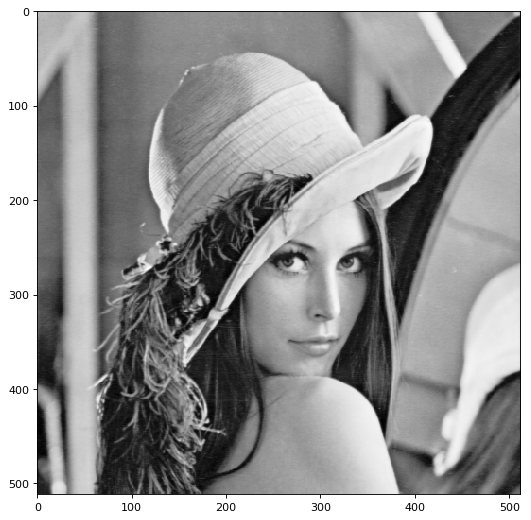

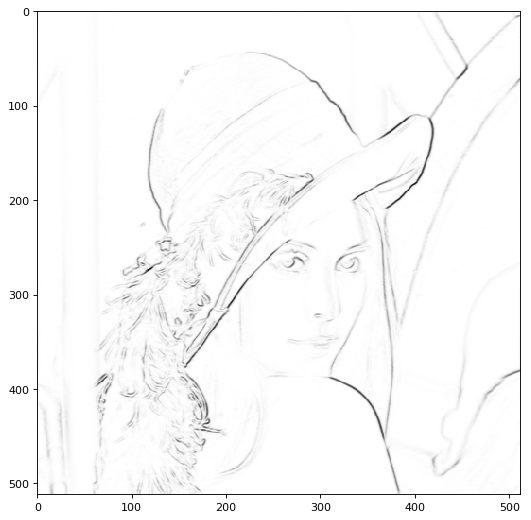

In [176]:
u = [img]
v = [v0]
e = 10
while (e > 10**-10) and (len(u) < 30):
    v.append(get_v(u[-1], c, alpha))
    u.append(get_u(u[0], v[-1], k_c, beta))
    e = np.sum(np.abs(u[-1] - u[-2]))/(512*512)
    print(e)
    
print("Número de iterações: ", len(u))
print(np.max(u[-1] - u[0]))
dicom.plot(u[0])
dicom.plot(u[-1])
dicom.plot(v[-1])

In [177]:
print(np.sum(v[1]*(D(0, 0, u[0])**2 + D(1, 0, u[0])**2)))
print(np.sum(v[-1]*(D(0, 0, u[-1])**2 + D(1, 0, u[-1])**2)))

362.38438815727244
357.13421600730044


In [17]:
xx, yy = np.mgrid[:512, :512]

In [18]:
bola = 255*(((xx - 256) ** 2 + (yy - 256) ** 2) < 100**2)

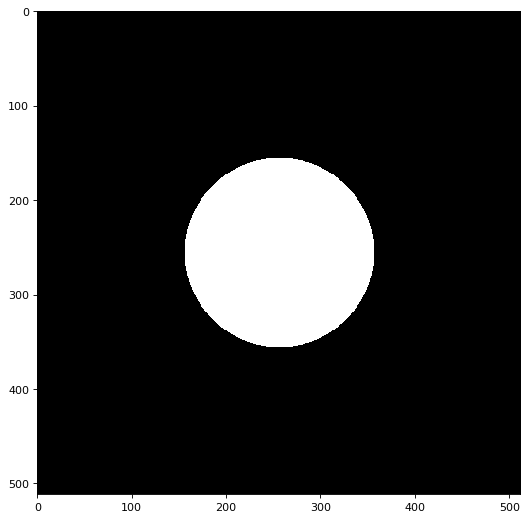

In [19]:
dicom.plot(bola)

In [20]:
vbola = get_v(bola, c, alpha)

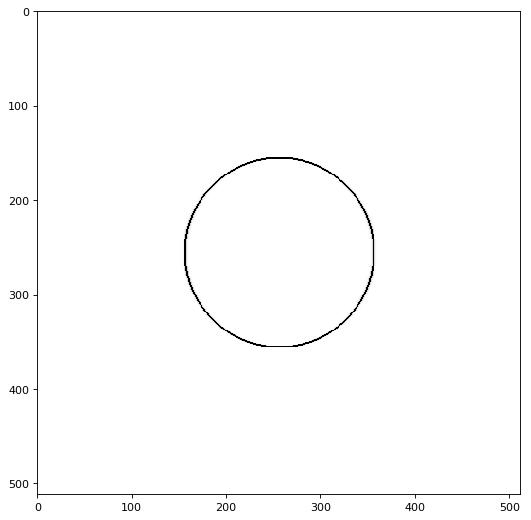

In [21]:
dicom.plot(vbola)

In [22]:
print(np.min(vbola), np.max(vbola))

0.0 1.0


In [31]:
img = dicom.trimmed_array[0]

alpha = 10**-5
beta = 10**-2
c = 10**3
k_c = .1*c

v0 = np.ones(img.shape)
#v0 = -np.ones(img.shape)
#v0[img > np.median(img)] = 1
#v0 = 1 - Dir(gaussian_filter(v0, 3))
#dicom.plot(v0)

In [56]:
def bourdin(img, v0, alpha, beta, c, k_c):
    u = [img]
    v = [v0]
    e = 10
    while (e > 1/255) and (len(u) < 40):
        v.append(get_v(u[-1], c, alpha))
        u.append(get_u(u[0], v[-1], k_c, beta))
        e = np.max(np.abs(u[-1] - u[-2]))
        #print(e)

    #print("Número de iterações: ", len(u))
    #print(np.sum(v[1]*(D(0, 0, u[0])**2 + D(1, 0, u[0])**2)))
    #print(np.sum(v[-1]*(D(0, 0, u[-1])**2 + D(1, 0, u[-1])**2)))
    #print(np.sum((u[-1] - np.mean(u[-1]))**2))
    #dicom.plot(u[0])
    #dicom.plot(u[-1])
    #dicom.plot(v[-1])
    
    return u[-1]


def recursive_bourdin(img, v0, alpha, beta, c, k_c, n):
    r = img
    for i in range(n):
        r = bourdin(r, v0, alpha, beta, c, k_c)
    return r

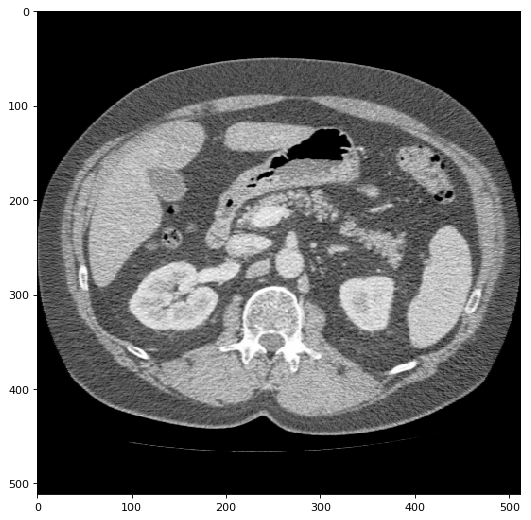

In [57]:
dicom.plot(recursive_bourdin(img, v0, alpha, beta, c, k_c, 1))

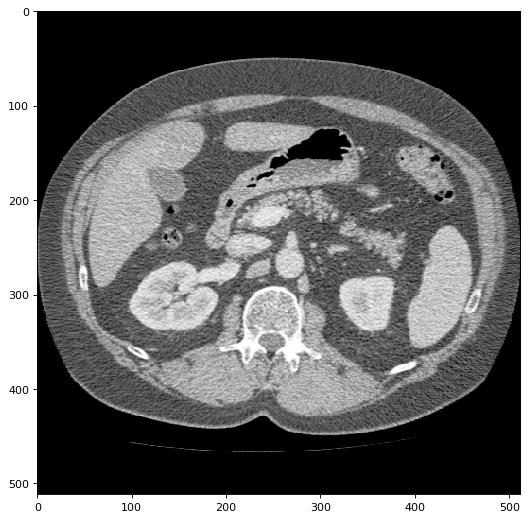

In [60]:
dicom.plot(recursive_bourdin(img, v0, alpha, 10000*beta, c, k_c, 1))